In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# For reproducible random results.
np.random.seed(789)

# The following utility functions are provided for your convenience.
# You may use them in your solution, or you may write your own.
# Do not alter them, and please read the docstrings carefully.
K = np.array([[471.14628085,  -4.94771211, 295.13159043], [0., 436.71106326, 240.96582594], [0., 0., 1.]])
SQUARE_SIZE = 0.0205

## Problem 1.1

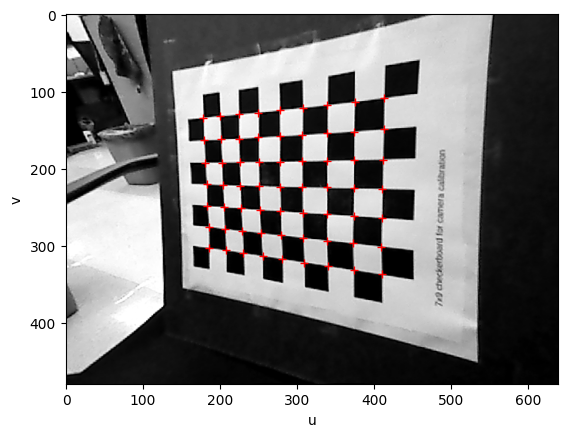

In [14]:
# Read the image from file
img_path = "p1_data/checkerboard.png"
image = cv2.imread(img_path, 0)

# Plot Corners on top of image
fig = plt.figure()
ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_ylabel("v")
ax.set_xlabel("u")

# 1) Find the corner locations of the chessboard in image space.
#    Hint: Use the function cv2.findChessboardCorners(image, (num_corners_x, num_corners_y))
#    Hint: findChessboardCorners outputs pixel coordinates!
# 2) Plot their location in image space over top of the image.
#    Hint: use ax.plot(...) -- should be one line!
#    Hint: This should only be 1 line of code!

ncorners_y = 7
ncorners_x = 9
# --------- YOUR CODE STARTS HERE ---------------
ncorners_y = 7
ncorners_x = 9
ret, corners = cv2.findChessboardCorners(image, (ncorners_x, ncorners_y))
corners = corners.squeeze()

ax.plot(corners[:, 0], corners[:, 1], "r+")
# --------- YOUR CODE ENDS HERE -----------------

## Problem 1.2

In [15]:
# 1)  Compute the homography, H.
#     1.a) Use the SQUARE_SIZE, and the dimensions of the grid above to
#             to create a the array P = [[X_0, Y_0, 1], .... [X_n, Y_n, 1]].
#             P should have shape (63, 3).
#          Hint: Use np.meshgrid to generate the X, Y coordinates, and
#             array.reshape and np.hstack to form the final matrix.
#     1.b) Form the M matrix outlined in the write-up!
#     1.c) Use np.linalg.svd(M) to solve for the nullspace of M and recover H.
#          Hint: np.linalg.svd(M) returns V.T.
#          Hint: Use <array>.reshape(3, 3) to give H the proper dimensions.
# 2)  Compute the camera pose rotation, R, and translation, t.
#     2.a) Compute KinvH = inv(K) @ H.
#          Hint: Use np.linalg.inv().
#     2.b) Normalize the values of KinvH to it's first column.
#          Hint: Use np.linalg.norm() and the / operator.
#     2.c) Compute r0, r1, r2, and t as outlined in the write-up.
#          Hint: Use np.cross().
#     2.d) Form R from r0, r1, and r2.
#          Hint: Use np.column_stack()

# --------- YOUR CODE STARTS HERE ---------------
Xg, Yg = np.meshgrid(
            SQUARE_SIZE * np.arange(ncorners_x),
            SQUARE_SIZE * np.arange(ncorners_y),
        )
Xg = Xg.reshape((-1, 1))
Yg = Yg.reshape((-1, 1))

P = np.hstack((Xg, Yg, np.ones_like(Xg)))

M_u = np.hstack((-P, np.zeros_like(P), corners[:, 0].reshape(-1, 1) * P))
M_v = np.hstack((np.zeros_like(P), -P, corners[:, 1].reshape(-1, 1) * P))
M = np.vstack((M_u, M_v))
_, _, V = np.linalg.svd(M)
H = V[-1].reshape(3, 3)

KinvH = np.linalg.inv(K) @ H

KinvH = KinvH / np.linalg.norm(KinvH[:, 0]) # Normalize to the first column

r0 = KinvH[:, 0]
r1 = KinvH[:, 1]
r2 = np.cross(r0, r1)
t = KinvH[:, 2]

R = np.column_stack([r0, r1, r2])

# --------- YOUR CODE ENDS HERE -----------------

## Problem 1.3

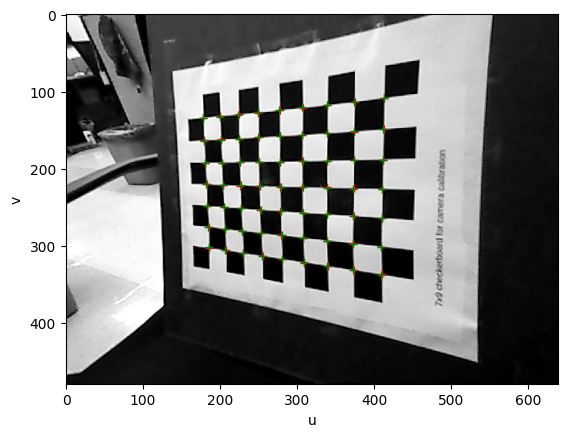

In [16]:
# 1) Finish the transform_world_to_camera function which uses
#       the given K, and the R and t that you calculated!.
#    Hint: You'll need to use some equations from the write-up.

def transform_world_to_camera(K, R, t, world_coords):
    """
    Args:
        K: np.array with shape (3, 3), camera intrinsics matrix.
        R: np.array with shape (3, 3), camera rotation.
        t: np.array with shape (3, ) or (3, 1), camera translation.
        world_coords: np.array with shape (N, 3), cartesian coordinates (X, Y, Z)
            in world frame to transform into camera pixel space.
    Return:
        uv: np.array with shape (N, 2), with (u, v) coordinates of that are
            the projections of the the world_coords on the image plane.
    """
    # --------- YOUR CODE STARTS HERE ---------------
    uv = []
    for i in range(world_coords.shape[0]):
        homog_pix = K.dot(R.dot(world_coords[i, :]) + t)
        uv_pnt = np.array([homog_pix[0] / homog_pix[2], homog_pix[1] / homog_pix[2]])
        uv.append(uv_pnt)
    uv = np.vstack(uv)

    # --------- YOUR CODE ENDS HERE -----------------
    return uv

ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_xlabel("u")
ax.set_ylabel("v")

# 2) Project the global coordinates of the corners that you calculated
#       earlier back onto the image using transform_world_to_camera.
#    Hint: The input world_coords should have shape (63, 3)
#    Hint: Use the Xs and Ys you got earlier and set Zs = 0.
#    Hint: You may need to change some of the variable names at the bottom
#       of this cell to match the names that you used above!

# --------- YOUR CODE STARTS HERE ---------------
corners_XYZ = np.hstack((Xg, Yg, np.zeros_like(Xg)))
uv_corners = transform_world_to_camera(K, R, t, corners_XYZ)
ax.plot(corners[:, 0], corners[:, 1], "r+")
ax.plot(uv_corners[:, 0], uv_corners[:, 1], "g+")
# --------- YOUR CODE ENDS HERE -----------------

## Project Anything!
Try using your the camera pose you computed to project our secret point cloud (defined in world coordinates) onto the camera frame!

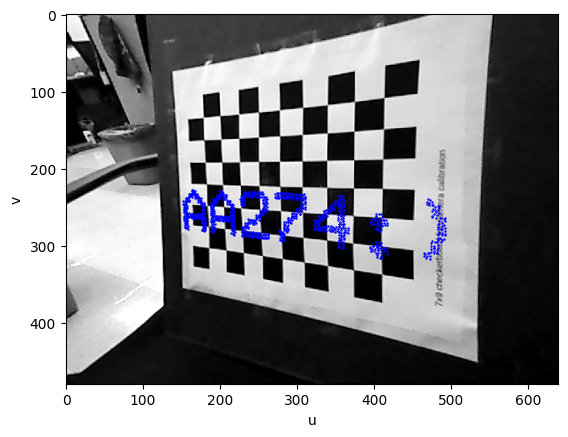

In [17]:
ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_xlabel("u")
ax.set_ylabel("v")

# Load the secrect point cloud from file!
point_cloud_secret = np.load("p1_data/secret.npy")

# NOTE: Uncomment the lines below when you've finished everything else!
uv_secret = transform_world_to_camera(K, R, t, point_cloud_secret)
ax.scatter(uv_secret[:, 0], uv_secret[:, 1], s=0.5, c="b")